## UnderComplete Autoencoders


In [1]:
# necessary imports
%matplotlib inline


import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
# some imports from bigdl
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.dataset.transformer import *



from pyspark import SparkContext
sc=SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[4]").set("spark.driver.memory","2g"))

# function to initialize the bigdl library
init_engine()

Using /home/ec2-user/wspace/libs/spark-2.2.0
Prepending /home/ec2-user/.local/lib/python3.4/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path


In [2]:
# bigdl provides a nice function for downloading and reading mnist dataset

from bigdl.dataset import mnist
mnist_path = "mnist"
images_train, labels_train = mnist.read_data_sets(mnist_path, "train")


# mean and stddev of the pixel values

mean = np.mean(images_train)
std = np.std(images_train)

# parallelize, center and scale the images_train
rdd_images =  sc.parallelize(images_train).map(lambda features: (features - mean)/std)


print("total number of images ",rdd_images.count())

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
total number of images  60000


In [4]:
# Parameters for training

BATCH_SIZE = 100
NUM_EPOCHS = 2

# Network Parameters
SIZE_HIDDEN = 32
# shape of the input data
SIZE_INPUT = 784 

In [5]:
# function for creating an autoencoder

def get_autoencoder(hidden_size, input_size):
    
    # Initialize a sequential type container
    module = Sequential()

    # create encoder layers
    module.add(Linear(input_size, hidden_size))
    module.add(ReLU())
    
    
    # create decoder layers
    module.add(Linear(hidden_size, input_size))
    module.add(Sigmoid())
    
    return(module)



In [6]:
undercomplete_ae = get_autoencoder( SIZE_HIDDEN, SIZE_INPUT)

# transform dataset to rdd(Sample) from rdd(ndarray). Sample represents a record in the dataset. A sample 
# consists of two tensors a features tensor and a label tensor. In our autoencoder features and label will be same
train_data = rdd_images.map(lambda x: Sample.from_ndarray(x.reshape(28*28), x.reshape(28*28)))

# Create an Optimizer
optimizer = Optimizer(
    model = undercomplete_ae,
    training_rdd = train_data,
    criterion = MSECriterion(),
    optim_method = Adam(),
    end_trigger = MaxEpoch(NUM_EPOCHS),
    batch_size = BATCH_SIZE)

# write summary 
app_name='undercomplete_autoencoder-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summary',
                                     app_name=app_name)


optimizer.set_train_summary(train_summary)

print("logs to saved to ",app_name)

creating: createSequential
creating: createLinear
creating: createReLU
creating: createLinear
creating: createSigmoid
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
creating: createTrainSummary
logs to saved to  undercomplete_autoencoder-20171202-085856


In [7]:
# run training process
trained_UAE = optimizer.optimize()


Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


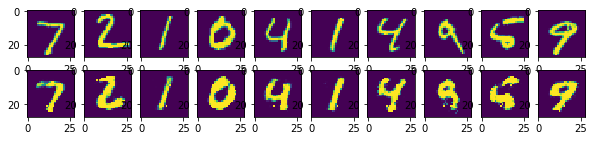

In [9]:
# let's check our model performance on the test data

(images, labels) = mnist.read_data_sets(mnist_path, "test")
rdd_test =  sc.parallelize(images).map(lambda features: ((features - mean)/std).reshape(28*28)).map(
                                                lambda features: Sample.from_ndarray(features, features))
examples = trained_UAE.predict(rdd_test).take(10)
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    a[0][i].imshow(np.reshape(images[i], (28, 28)))
    a[1][i].imshow(np.reshape(examples[i], (28, 28)))